In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import StandardScaler
import torch
from torch.autograd import Variable
import pandas as pd
print(torch.cuda.is_available())
import csv

True


In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
df = pd.read_csv('Steels_kaggle.csv')
column_slice = df.iloc[:, 1:16]
data = column_slice.to_numpy()

In [3]:
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

In [4]:
model = torch.load("C:\DATA\Progi\ML_KRUGLOV\EGOR\model_steels.pth")

C:\Users\Егор\AppData\Local\Temp\ipykernel_2984\3227696143.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("C:\DATA\Progi\ML_KRUGLOV\EGOR\model_steels

In [5]:
np.set_printoptions(precision=6, suppress=True)

In [11]:
import numpy as np
import random
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

class EGOR:
    def __init__(self, model, scaler, population_size=20, num_generations=50, mutation_rate=0.1, number_parameters= 15, search_range=(-1, 1)):
        self.model = model  # Обученная модель
        self.scaler = scaler  # Scaler для обратного преобразования
        self.population_size = population_size
        self.num_generations = num_generations
        self.mutation_rate = mutation_rate
        self.search_range = search_range
        self.number_parameters = number_parameters
        self.history = []  # Хранение лучших особей и их фитнес-функций
        self.fitness_values = []
        self.stagnation_counter = 0  # Счётчик стагнации
        self.best_fitness_overall = None
        self.min_values = [9.0e-02, 1.8e-01, 4.2e-01, 6.0e-03, 3.0e-03, 0.0e+00, 0.0e+00, 5.0e-03, 0.0e+00,
                        0.0e+00, 2.0e-03, 2.5e-03, 0.0e+00, 0.0e+00, 2.7e+01]
        self.max_values = [3.40e-01, 5.20e-01, 1.48e+00, 3.00e-02, 2.20e-02, 6.00e-01, 1.31e+00, 1.35e+00,
                        2.50e-01, 3.00e-01, 5.00e-02, 1.50e-02, 4.37e-01, 1.70e-03, 6.50e+02]
        self.population = [np.random.uniform(self.min_values, self.max_values) for _ in range(population_size)]
        self.log_filename = "C:/DATA/Progi/ML_KRUGLOV/EGOR/logs/log.csv" 
        self.select_best_size = 0.3
        self.num_new = int(0.3 * self.population_size)
        self.num_mutated = int(0.2 * self.population_size)
        # Создание новых особей путём наследования
        self.num_crossover = int(0.3 * self.population_size)
        # Создание новых особей путём смешивания параметров
        self.num_mixed = int(0.2 * self.population_size)
    def log_generation(self, generation, best_individual, best_fitness, ind_max):
        """Записывает информацию о текущем поколении в файл."""
        if ind_max < self.select_best_size:
            creation_method = "Save_best"
        elif ind_max < self.select_best_size+self.num_new:
            creation_method = "Random"
        elif ind_max < self.select_best_size+self.num_new + self.num_mutated:
            creation_method = "Mutated"
        elif ind_max < self.select_best_size+self.num_new + self.num_mutated + self.num_crossover:
            creation_method = "Crossover"
        elif ind_max < self.select_best_size+self.num_new + self.num_mutated + self.num_crossover+self.num_mixed:
            creation_method = "Mixed"
        else:
            creation_method = "Mixed"
        with open(self.log_filename, mode='a', newline='') as file:
            writer = csv.writer(file)
            rounded_data = np.round(best_individual, 3)
            writer.writerow([generation, *rounded_data, best_fitness, creation_method])
        
    def fitness_function(self, param):
        """Функция оценки для оптимизации."""
        param = torch.tensor(self.scaler.transform(param.reshape(1,-1)), dtype=torch.float32) # Преобразование в тензор
        prediction = self.model(param)
        return prediction.item()  # Получение скалярного значения из тензора
    def select_best(self):
        """Возвращает 20% лучших особей."""
        sorted_indices = np.argsort(self.fitness_values)[::-1]  # Сортировка по убыванию
        num_best = int(0.2 * self.population_size)
        best_indices = sorted_indices[:num_best]
        return [self.population[i] for i in best_indices]


    def calculate_fitness_values(self):
        """Вычисляет фитнес для всех особей текущего поколения."""
        self.fitness_values = [self.fitness_function(ind) for ind in self.population]

    def generate_new(self):
        """Создаёт одну новую случайную особь."""
        return np.random.uniform(self.min_values, self.max_values)

    def mutate(self, individual):
        """Создаёт новую особь путём мутации."""
        for i in range(self.number_parameters): 
            if random.random() < self.mutation_rate:
                supplement = random.uniform(-0.01, 0.01)
                if self.min_values[i] <= individual[i] + supplement <= self.max_values[i]:
                    individual[i] += supplement
        return individual

    def crossover(self, parents):
        """Создаёт одну новую особь путём наследования половины параметров от двух родителей."""
        parent1, parent2 = parents
        split_index = len(parent1) // 2
        child = np.concatenate((parent1[:split_index], parent2[split_index:]))
        return child

    def mix_parameters(self, parents):
        """Создаёт одну новую особь путём смешивания параметров двух родителей."""
        parent1, parent2 = parents
        alpha = random.uniform(0, 1)
        return alpha * parent1 + (1 - alpha) * parent2

    def crit(self, individual):
        """Критерий D-оптимальности для новых особей на основе матрицы дизайна."""
        individual = np.array(individual).reshape(1, -1)
        
        origin = self.scaler.inverse_transform(np.array([individual]))[0]
        if origin.min() <= 0:
            return False
        return True

    def evolve_population(self):
        """Создаёт новое поколение с сохранением, мутацией и добавлением новых."""
        best = self.select_best()

        # Создание новых случайных особей
        new = [self.generate_new() for _ in range(self.num_new)]

        # Создание новых особей путём мутации
        mutated = [self.mutate(random.choice(best)) for _ in range(self.num_mutated)]

        # Создание новых особей путём наследования
        crossover = [self.crossover(random.sample(best, 2)) for _ in range(self.num_crossover)]

        # Создание новых особей путём смешивания параметров
        mixed = [self.mix_parameters(random.sample(best, 2)) for _ in range(self.num_mixed)]

        # Собираем новые особи в одном списке
        new_population = best + new + mutated + crossover + mixed

        # Применяем критерий D-оптимальности и фильтруем особей
        filtered_population = []
        for individual in new_population:
            if True:  # Если особь проходит по D-оптимальности
                filtered_population.append(individual)

        # Если количество особей меньше, чем требуемое (из-за фильтрации), добавляем случайные особи
        while len(filtered_population) < self.population_size:
            filtered_population.append(self.generate_new())

        self.population = filtered_population

    def stopping_criterion(self, generation):
        """Критерий остановки алгоритма."""
        if generation >= self.num_generations:
            print("Stop by num_generate")
            return True

        # current_best_fitness = self.fitness_function(self.population[0])
        # if self.best_fitness_overall is None or current_best_fitness < self.best_fitness_overall:
        #     self.best_fitness_overall = current_best_fitness
        #     self.stagnation_counter = 0
        # else:
        #     self.stagnation_counter += 1

        # if self.stagnation_counter >= 10:
        #     print("Stop by constant")
        #     return True

        return False
    def run(self):
        """Запускает эволюционный алгоритм."""
        generation = 0
        with open(self.log_filename, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Generation','C', 'Si', 'Mn', 'P', 'S', 'Ni', 'Cr', 'Mo', 'Cu','V', 'Al', 'N','Ceq','Nb + Ta', 'Temperature (°C)', '0.2% Proof Stress (MPa)', 'CreationMethod'])

        while not self.stopping_criterion(generation):
            self.calculate_fitness_values()  # Вычисляем фитнес-функции
            ind_max = np.argmax(self.fitness_values)
            best_individual = self.population[ind_max]
            best_fitness = max(self.fitness_values)

            # Сохранение лучшей особи и её фитнес-функции
            self.history.append((best_individual, best_fitness))

            print(f"Поколение {generation+1}: Лучшая приспособленность = {best_fitness}")
            self.log_generation(
                generation,
                best_individual,
                best_fitness,
                ind_max
                )
            self.evolve_population()
            generation += 1

        # Финальные значения
        self.calculate_fitness_values()
        best_param = self.population[np.argmax(self.fitness_values)]
        best_fitness = max(self.fitness_values)

        # Обратное преобразование параметра
        best_param_original = self.scaler.inverse_transform(np.array([best_param]))[0]
        print(f"Оптимальное значение параметра (оригинальное): {best_param_original}")
        print(f"Приспособленность: {best_fitness}")

        return best_param, best_param_original, best_fitness


In [14]:
ea = EGOR(model=model, scaler=scaler, population_size=1000, num_generations=1000, mutation_rate=0.2, search_range=(-0.9,1))

# Запуск оптимизации
best_param, best_param_original, best_fitness = ea.run()

# Вывод истории
print("История оптимальных особей:")
num_gen = []
fitness_arr = []
for generation, (individual, fitness) in enumerate(ea.history, 1):
    num_gen.append(generation)
    fitness_arr.append(fitness)
    print(f"Поколение {generation}: Особь = {individual}, Приспособленность = {fitness}")
plt.scatter(num_gen,fitness_arr)


Поколение 1: Лучшая приспособленность = 946.4120483398438
Поколение 2: Лучшая приспособленность = 1004.4141845703125
Поколение 3: Лучшая приспособленность = 1020.3115844726562
Поколение 4: Лучшая приспособленность = 1020.3115844726562
Поколение 5: Лучшая приспособленность = 1055.694091796875
Поколение 6: Лучшая приспособленность = 1079.6123046875
Поколение 7: Лучшая приспособленность = 1102.463623046875
Поколение 8: Лучшая приспособленность = 1106.6829833984375
Поколение 9: Лучшая приспособленность = 1116.5155029296875
Поколение 10: Лучшая приспособленность = 1127.888427734375
Поколение 11: Лучшая приспособленность = 1126.184326171875
Поколение 12: Лучшая приспособленность = 1140.22705078125
Поколение 13: Лучшая приспособленность = 1142.281982421875
Поколение 14: Лучшая приспособленность = 1148.547119140625
Поколение 15: Лучшая приспособленность = 1147.4793701171875
Поколение 16: Лучшая приспособленность = 1150.5281982421875
Поколение 17: Лучшая приспособленность = 1154.4869384765625
П

KeyboardInterrupt: 

История оптимальных особей:
Поколение 1: Особь = [ 0.187566  0.278497  0.987565  0.029509  0.009686  0.550081  1.201498
  0.484097  0.022917  0.254716  0.040074  0.005205  0.367148  0.001612
 32.445648], Приспособленность = 946.4120483398438
Поколение 2: Особь = [ 0.253912  0.273684  1.429794  0.00909   0.008838  0.30002   0.929612
  1.294679  0.143787  0.270079  0.048486  0.008026  0.420667  0.001699
 53.093018], Приспособленность = 1004.4141845703125
Поколение 3: Особь = [ 0.293151  0.209208  1.426992  0.011186  0.018147  0.581328  0.607763
  1.302853  0.160965  0.276554  0.037592  0.011649  0.396227  0.001548
 53.07297 ], Приспособленность = 1020.3115844726562
Поколение 4: Особь = [ 0.293151  0.209208  1.426992  0.011186  0.018147  0.581328  0.607763
  1.302853  0.160965  0.276554  0.037592  0.011649  0.396227  0.001548
 53.07297 ], Приспособленность = 1020.3115844726562
Поколение 5: Особь = [ 0.293151  0.209208  1.426992  0.011186  0.018147  0.581328  0.607763
  1.302853  0.160965 

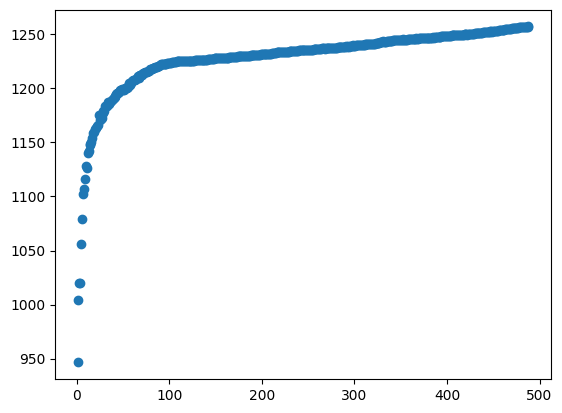

In [15]:
print("История оптимальных особей:")
num_gen = []
fitness_arr = []
for generation, (individual, fitness) in enumerate(ea.history, 1):
    num_gen.append(generation)
    fitness_arr.append(fitness)
    print(f"Поколение {generation}: Особь = {individual}, Приспособленность = {fitness}")
plt.scatter(num_gen,fitness_arr)

Text(0, 0.5, 'Proof Stress')

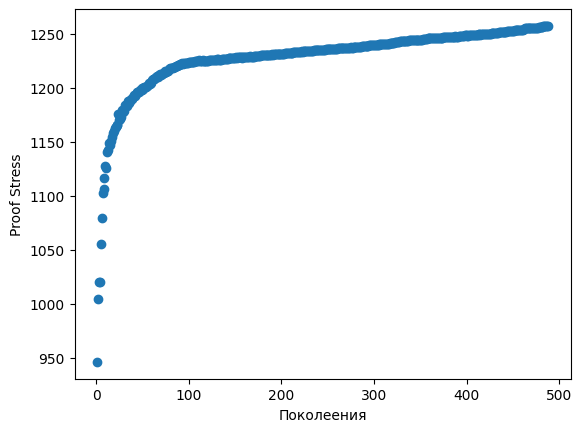

In [16]:
plt.scatter(num_gen,fitness_arr)
plt.xlabel("Поколеения")
plt.ylabel("Proof Stress")